# Intersection of BCEA areas

In [1]:
import dataset
import numpy as np
import ipyplot
import matplotlib.pyplot as plt

from preprocessing import load_npy, all_part_identifiers
from skimage.transform import resize

## AMD group BCEA intersection and union

In [2]:
_ = dataset.initialize('/home/ja8818/code/config/dataset.txt')

In [3]:
def pad_equally_around(img, target_size):
    total_pad = target_size - img.shape[0]
    leading_pad = total_pad // 2
    trailing_pad = total_pad - leading_pad
    return np.pad(img, ((leading_pad, trailing_pad), (leading_pad, trailing_pad)))

In [4]:
def compute_bcea_areas_measure(identifiers, measure, labels_folder, return_bcea_images=False):
    assert measure in {'intersection', 'union'}, 'Unknown measure specified'

    def load_label_image(identifier):
        lbl_image = load_npy(labels_folder, identifier)
        # Dense (full) scan images have smaller resolution than detail (up/centre/down)
        if lbl_image is not None:
            if lbl_image.shape[0] != 1536:
                lbl_image = resize(lbl_image, (1536,) * 2, order=0)
            return lbl_image
        else:
            return None

    def crop_image_to_bcea_ellipse(img):
        label_indices = np.argwhere(img > 0)
        y_min, y_max = label_indices[:, 0].min(), label_indices[:, 0].max()
        x_min, x_max = label_indices[:, 1].min(), label_indices[:, 1].max()
        height, width = y_max - y_min + 1, x_max - x_min + 1
        side_len = max(height, width)
        if height > width:
            total_pad = side_len - width
            x_pad = total_pad // 2
            return image[y_min:y_max + 1, x_min - x_pad:x_max + (total_pad - x_pad) + 1]
        else:
            total_pad = side_len - height
            y_pad = total_pad // 2
            return image[y_min - y_pad:y_max + (total_pad - y_pad) + 1, x_min:x_max + 1]

    images = []
    for identifier in identifiers:
        image = load_label_image(identifier)
        if image is not None:
            images.append(crop_image_to_bcea_ellipse(image))

    largest_size = np.max(list(map(lambda img: img.shape[0], images)))
    if measure == 'intersection':
        measure_output = np.ones((largest_size,) * 2)
    else:  # union
        measure_output = np.zeros((largest_size,) * 2)

    for i in range(len(images)):
        images[i] = pad_equally_around(images[i], largest_size)
        if measure == 'intersection':
            measure_output = np.logical_and(measure_output, images[i])
        else:  # union
            measure_output = np.logical_or(measure_output, images[i])

    if return_bcea_images:
        return measure_output, images
    else:
        return measure_output

In [5]:
part_identifiers = all_part_identifiers()
amd_left_identifiers = [iden for iden in part_identifiers if iden.group == 'amd' and iden.eye == 'left']
amd_right_identifiers = [iden for iden in part_identifiers if iden.group == 'amd' and iden.eye == 'right']
control_left_identifiers = [iden for iden in part_identifiers if iden.group == 'control' and iden.eye == 'left']
control_right_identifiers = [iden for iden in part_identifiers if iden.group == 'control' and iden.eye == 'right']
labels_folder = '/home/ja8818/data/preprocessing/warped_labels'

In [6]:
intersection_left, bceas_left = compute_bcea_areas_measure(
    amd_left_identifiers, 'intersection', labels_folder, return_bcea_images=True
)
union_left = compute_bcea_areas_measure(
    amd_left_identifiers, 'union', labels_folder, return_bcea_images=False
)

In [7]:
# ipyplot.plot_images(bceas_left, img_width=100)

In [8]:
intersection_right, bceas_right = compute_bcea_areas_measure(
    amd_right_identifiers, 'intersection', labels_folder, return_bcea_images=True
)
union_right = compute_bcea_areas_measure(
    amd_right_identifiers, 'union', labels_folder, return_bcea_images=False
)

In [9]:
# ipyplot.plot_images(bceas_right, img_width=100)

In [10]:
def plot_measures(measure, group, left, right):
    fig, axs = plt.subplots(1, 2, figsize=(15, 8))
    fig.suptitle(f'{measure.capitalize()} in {group} group', fontsize=15)
    axs[0].imshow(pad_equally_around(left, 1536), cmap='gray')
    axs[0].set_title('Left eye')
    axs[0].axis('off') # Turn off axis in subplots: https://stackoverflow.com/a/25864515
    axs[1].imshow(pad_equally_around(right, 1536), cmap='gray')
    axs[1].set_title('Right eye')
    axs[1].axis('off')
    plt.show()

In [11]:
# plot_measures('intersections', 'AMD', intersection_left, intersection_right)

In [12]:
# plot_measures('unions', 'AMD', union_left, union_right)

In [13]:
def intersection_percentages(intersection, bceas):
    n_pixels_intersection = np.count_nonzero(intersection)
    return [n_pixels_intersection / np.count_nonzero(bcea) for bcea in bceas]

def union_percentages(union, bceas):
    n_pixels_union = np.count_nonzero(union)
    return [np.count_nonzero(bcea) / n_pixels_union for bcea in bceas]

In [14]:
left_intersection_fractions = intersection_percentages(intersection_left, bceas_left)
right_intersection_fractions = intersection_percentages(intersection_right, bceas_right)
left_union_fractions = union_percentages(union_left, bceas_left)
right_union_fractions = union_percentages(union_right, bceas_right)

In [15]:
# Map to strings
left_intersection_fractions_str = list(map(lambda a: str(a), left_intersection_fractions))
right_intersection_fractions_str = list(map(lambda a: str(a), right_intersection_fractions))
left_union_fractions_str = list(map(lambda a: str(a), left_union_fractions))
right_union_fractions_str = list(map(lambda a: str(a), right_union_fractions))

In [16]:
with open('/home/ja8818/data/intersections_unions.txt', 'w') as file:
    file.write(f"AMD left eye intersection fractions: {' '.join(left_intersection_fractions_str)}\n")
    file.write(f"AMD right eye intersection fractions: {' '.join(right_intersection_fractions_str)}\n")
    file.write(f"AMD left eye union fractions: {' '.join(left_union_fractions_str)}\n")
    file.write(f"AMD right eye union fractions: {' '.join(right_union_fractions_str)}\n")

In [17]:
def plot_measure_share_fractions(measure, left_fractions, right_fractions):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    _ = axs[0].hist(left_fractions, bins=10, range=(0,1))
    axs[0].set_xticks(np.arange(0, 1.1, step=0.1))
    axs[0].set_title('Left eye')
    axs[0].set_ylabel('# of label images')
    axs[0].set_xlabel(f'Fraction of area common with {measure}')

    _ = axs[1].hist(right_fractions, bins=10, range=(0,1))
    axs[1].set_xticks(np.arange(0, 1.1, step=0.1))
    axs[1].set_title('Right eye')
    axs[1].set_ylabel('# of label images')
    axs[1].set_xlabel(f'Fraction of area common with {measure}')

    _ = axs[2].hist(left_fractions + right_fractions, bins=10, range=(0,1))
    axs[2].set_xticks(np.arange(0, 1.1, step=0.1))
    axs[2].set_title('Both eyes')
    axs[2].set_ylabel('# of label images')
    axs[2].set_xlabel(f'Fraction of area common with {measure}')
    plt.show()

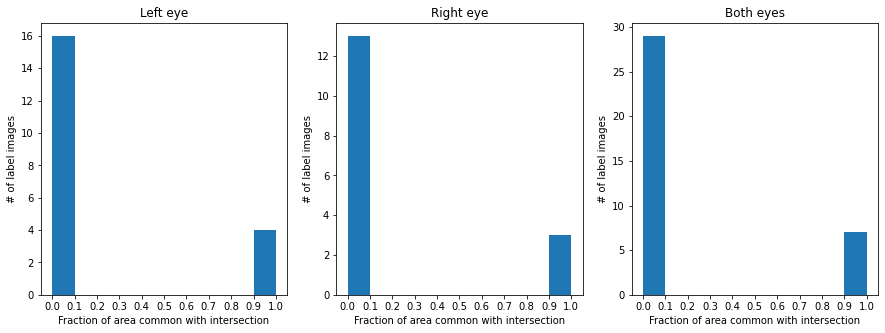

In [18]:
plot_measure_share_fractions('intersection', left_intersection_fractions, right_intersection_fractions)

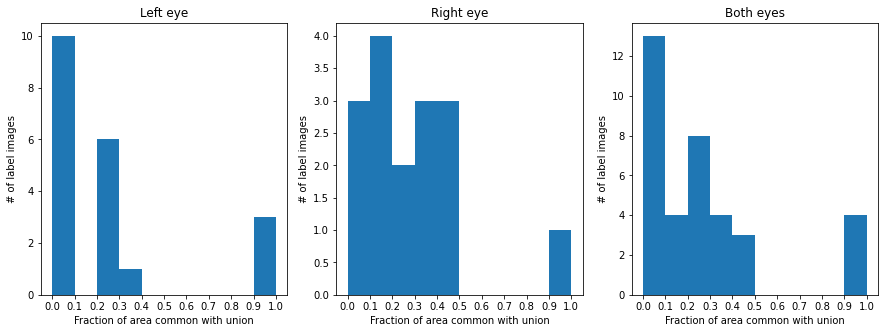

In [19]:
plot_measure_share_fractions('union', left_union_fractions, right_union_fractions)

## Control group BCEA intersection and union

In [20]:
intersection_right, bceas_right = compute_bcea_areas_measure(
    control_right_identifiers, 'intersection', labels_folder, return_bcea_images=True
)
union_right = compute_bcea_areas_measure(
    control_right_identifiers, 'union', labels_folder, return_bcea_images=False
)

In [21]:
# ipyplot.plot_images(bceas_left, img_width=100)

In [22]:
intersection_left, bceas_left = compute_bcea_areas_measure(
    control_left_identifiers, 'intersection', labels_folder, return_bcea_images=True
)
union_left = compute_bcea_areas_measure(
    control_left_identifiers, 'union', labels_folder, return_bcea_images=False
)

In [23]:
# ipyplot.plot_images(bceas_right, img_width=100)

In [24]:
# plot_measures('intersections', 'control', intersection_left, intersection_right)

In [25]:
# plot_measures('unions', 'control', union_left, union_right)

In [26]:
left_intersection_fractions = intersection_percentages(intersection_left, bceas_left)
right_intersection_fractions = intersection_percentages(intersection_right, bceas_right)
left_union_fractions = union_percentages(union_left, bceas_left)
right_union_fractions = union_percentages(union_right, bceas_right)

In [27]:
# Map to strings
left_intersection_fractions_str = list(map(lambda a: str(a), left_intersection_fractions))
right_intersection_fractions_str = list(map(lambda a: str(a), right_intersection_fractions))
left_union_fractions_str = list(map(lambda a: str(a), left_union_fractions))
right_union_fractions_str = list(map(lambda a: str(a), right_union_fractions))

In [28]:
with open('/home/ja8818/data/intersections_unions.txt', 'a') as file:
    file.write(f"Control left eye intersection fractions: {' '.join(left_intersection_fractions_str)}\n")
    file.write(f"Control right eye intersection fractions: {' '.join(right_intersection_fractions_str)}\n")
    file.write(f"Control left eye union fractions: {' '.join(left_union_fractions_str)}\n")
    file.write(f"Control right eye union fractions: {' '.join(right_union_fractions_str)}\n")

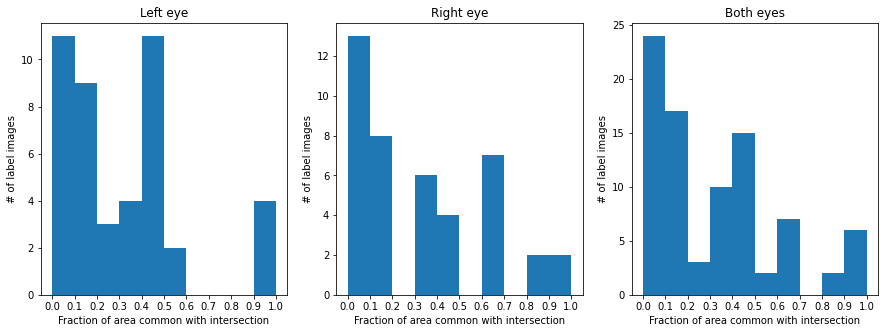

In [29]:
plot_measure_share_fractions('intersection', left_intersection_fractions, right_intersection_fractions)

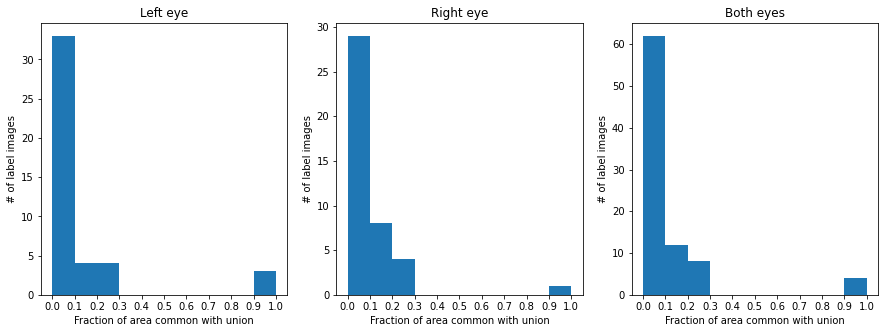

In [30]:
plot_measure_share_fractions('union', left_union_fractions, right_union_fractions)